# Model
Image segmentation model with U-Net architecture, leveraging feature layers from trained ResNet model. 

# Losses
We define a module for making custom losses out of loss function primatives. 

## Loss function primitives
Two types of distance function. Optional spatial blur in the loss to include spatial information. It may help with finding the global optimum more quickly. Wasserstein distance includes distance by definition. 

*   **Dice**
*   **Binary Cross Entropy**

*   **Jensen-Shannon Divergence**
*   **Wasserstein/ Sinkhorn approximation (work in progress)** - This can be approximated using an iterative matrix formulation. Therefore we can backprop gradients through this loss layer!

The last two are distances between probability on the rectangle. The first are distances between conditional probability pixel = 1 give x,y coordinate.



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@markdown #**Select data directory**
#@markdown ---

project_drive = '' #@param {type:"string"}
data_drive = '/data'#@param {type:"string"}

str2=project_drive+data_drive
print(str2)
#!ls str

/content/drive/My Drive/ToAbdullah/MedicalUNETProject/data


# Load Data

In [ ]:
train_dict = torch.load(project_drive+data_drive+'/train_dic.pt')
val_dict = torch.load(project_drive+data_drive+'/val_dic.pt')
#test_dict = torch.load(project_drive+data_drive+'/test_dic.pt')

SimDataSet modifications

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import random

def grad_contour(mask):
    #Takes a torch array of size N_data x Channels x Height x Width
    #Return the contour using square of gradient.
    return(torch.square((mask[:,:,:-1,:-1]-mask[:,:,1:,:-1]))+torch.square((mask[:,:,:-1,:-1]-mask[:,:,:-1,1:])))

class ImageLabelDataset(Dataset):
    def __init__(self, images, codes, labels, transform=None,rand_rot=False):
    #self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)

        self.permutation = np.random.permutation(images.shape[0])
        self.input_images = images[self.permutation,:,:]
        self.codes = codes[self.permutation,:]
        self.target_masks = labels[self.permutation,:,:,:]
        self.transform = transform
        self.rand_rot = rand_rot
        self.rotate = torchvision.transforms.RandomRotation(180)
        self.upsample = torchvision.transforms.Resize((256,256))     #nn.Upsample(size=(256,256), mode='bilinear', align_corners=True)


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx,expand=True,):
        image = self.input_images[idx,:,:]
        code = self.codes[idx,:,:,:]
        mask = self.target_masks[idx,:,:,:]
        if self.rand_rot:
            img_mask = self.rotate(torch.concat([image.unsqueeze(0),mask],dim=0))
            image = img_mask[0,:,:]
            mask = img_mask[-5:,:,:]

        if self.transform is not None:
            image = self.transform(image)
        if expand:
            image = image.unsqueeze(0).expand(3,-1,-1) #image was already resized
            #this makes it 3x64x64
        else:
            image = image

        contour = torch.square((mask[:,:-1,:-1]-mask[:,1:,:-1]))+torch.square((mask[:,:-1,:-1]-mask[:,:-1,1:]))
        contour = (contour>0).type(torch.float32)
        contour = self.upsample(contour.unsqueeze(0))[0]
        
        return image, code, mask, contour
    def enable_flipping(self):
        self.rand_rot = True
    def disable_flipping(self):
        self.rand_rot = False

Test dataset

In [ ]:
train_dataset = ImageLabelDataset(train_dict['images'].type(torch.float32), train_dict['codes'].type(torch.float32),train_dict['labels'].type(torch.float32))
#test_dataset = ImageLabelDataset(test_dict['images'], test_dict['codes'],test_dict['labels'])
val_dataset = ImageLabelDataset(val_dict['images'].type(torch.float32), val_dict['codes'].type(torch.float32),val_dict['labels'].type(torch.float32))

#dataloaders_all = {
 # 'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
  #'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#}



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
del(train_dict)
#del(test_dict)
del(val_dict)

torch.Size([5, 256, 256])

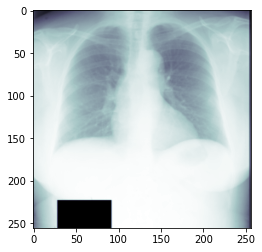

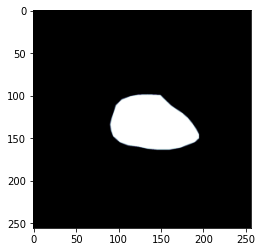

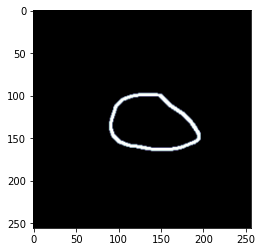

In [ ]:
img, code, mask, contour = train_dataset.__getitem__(0)
plt.figure()
plt.imshow(img[0], 'bone')
plt.figure()
plt.imshow(torch.sum(mask,0),'bone')
plt.figure()
plt.imshow(torch.sum(contour,0),'bone')
contour.shape
#img.shape
#mask.shape

# U-Net Model

In [ ]:
# Will make encoder, decoder nets.
# Network containing both encoder decoder

import torch.nn as nn
import torchvision.models

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_original_size0 = convrelu(3, 64, 3, 1) #convrelu(Num_channels, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        for l in self.base_layers:
            for param in l.parameters():
                param.requires_grad = False
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32) 

     

    def forward(self, input):
        input=input.float()
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        features0 = self.layer0(input)
        features1 = self.layer1(features0)
        features2 = self.layer2(features1)
        features3 = self.layer3(features2)
        features4 = self.layer4(features3)
        

        return x_original,features0,features1,features2,features3,features4

class Decoder(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.conv_final = convrelu(64 + 128, 64, 3, 1) #        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        #now Num_channels=1 not Num_channels=3
        # labels are 256 x 256 OR you could resize the mask 
        

        self.conv_last = nn.Conv2d(64,n_class, 1)
    
    def forward(self, x_original,layer0,layer1,layer2,layer3,layer4):
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_final(x) # x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda


In [ ]:
# Try encoder and decoder
from torchsummary import summary
encoder = Encoder()
encoder = encoder.to(device)
summary(encoder,input_size = (3,256,256))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [ ]:
import torch.nn as nn
import torchvision.models

class EncDecResNetUNet(nn.Module):
    def __init__(self,n_class=10):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder(n_class = n_class)
    
    def forward(self, input):
        x_original,features0,features1,features2,features3,features4 = self.encoder(input)
        out = self.decoder(x_original,features0,features1,features2,features3,features4)
        
        return out


In [ ]:
from torchsummary import summary

In [ ]:
model = EncDecResNetUNet(10)
model = model.to(device)
summary(model,input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]           9,408
            Conv2d-6         [-1, 64, 128, 128]           9,408
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

# Define Visualization

In [ ]:
img, code, mask, contour = next(iter(train_dataloader))

img = img.to(device) 
code = code.to(device) 
mask = mask.to(device) 
contour = contour.to(device)

prediction=model(img)

vis_img = img.cpu()[0]
vis_prediction = prediction.cpu()[0]
vis_mask = mask.cpu()[0]
vis_contour = contour.cpu()[0]
contour.dtype

torch.float32

In [ ]:
def visualize(vis_img,vis_prediction,vis_mask,vis_contour,epoch,dir):
    f,ax = plt.subplots(2,2,figsize=(10,10))
    ax[0,0].imshow(vis_img[0],cmap='bone',vmin=.3)
    ax[0,0].set_title('image epoch:'+str(epoch),fontsize=20)

    ax[1,0].imshow(np.sum(vis_prediction[:5].detach().numpy(),0),cmap='Greys')
    ax[1,0].set_title('all predicted masks epoch:'+str(epoch),fontsize=20)

    ax[1,1].imshow(np.sum(vis_prediction[-5:].detach().numpy(),0),cmap='Greys')
    ax[1,1].set_title('all predicted contours epoch:'+str(epoch),fontsize=20)

    ax[0,1].imshow(torch.sum(vis_mask,0),cmap='Greys')
    ax[0,1].set_title('truth epoch:'+str(epoch),fontsize=20)
    f.tight_layout()
    f.savefig(dir+str(epoch)+'img_mask_pred.png')

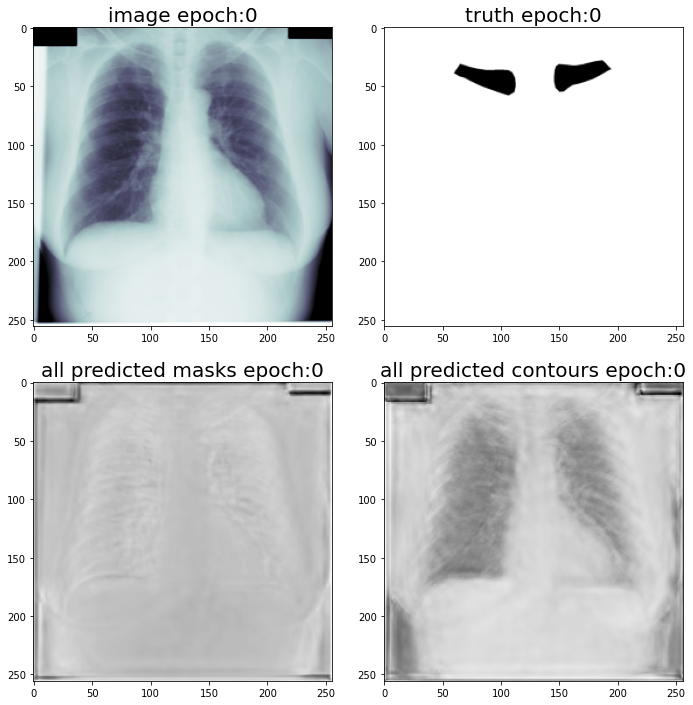

In [ ]:
visualize(vis_img,vis_prediction,vis_mask,vis_contour,epoch=0,dir='')

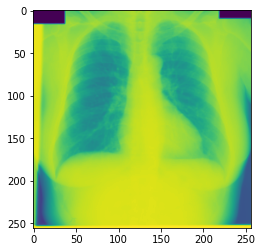

In [ ]:
plt.imshow(vis_img[0].flatten(start_dim=0).view((256,256)))

# Loss function primitives
Two types of distance function. Optional spatial blur in the loss to include spatial information. It may help with finding the global optimum more quickly.

*   Dice
*   Binary Cross Entropy

*   Jensen-Shannon Divergence
*   Wasserstein/ Sinkhorn approximation (work in progress)

The last two are distances between probability on the rectangle. The first are distances between conditional probability pixel = 1 give x,y coordinate.


In [ ]:

def uniform_filter(kernel_size,n_channel,padding = None):
    if padding is None:
        uf = nn.Conv2d(n_channel,n_channel, kernel_size= kernel_size,  padding=int(np.round((kernel_size-1)/2)), bias=False)
    else:
        uf = nn.Conv2d(n_channel,n_channel, kernel_size= kernel_size,  padding=padding, bias=False)
    uf.weight.data = nn.Parameter(torch.ones_like(uf.weight,dtype=torch.float32),requires_grad = False)
    uf.weight.data = n_channel*uf.weight.data/torch.sum(uf.weight.data)
    return uf


class BCEBlurLoss(nn.Module):
    def __init__(self,kernel_size,channels):
        super(BCEBlurLoss, self).__init__()
        self.channels = channels
        self.blurrer = uniform_filter(kernel_size,len(channels))
        for param in self.blurrer.parameters():
            param.requires_grad = False
    def forward(self,target,prediction,code):
        target = target[:,self.channels,:,:]
        prediction = prediction[:,self.channels,:,:]
        #print(target.dtype)

        prediction = torch.sigmoid(prediction)
        return F.binary_cross_entropy(code*self.blurrer(prediction),target)


class JSBlurLoss(nn.Module): #keep in mind target = target / torch.sum(target,(2,3))
    def __init__(self,kernel_size,channels):
        super(JSBlurLoss, self).__init__()
        self.channels = channels
        self.blurrer = uniform_filter(kernel_size,len(channels),padding=kernel_size)

        for param in self.blurrer.parameters():
            param.requires_grad = False
        self.KLdiv = lambda p,q : torch.sum(torch.mean(p*torch.log(p/q),(0,1)))

    def forward(self,target,prediction,code):
        target = target[:,self.channels,:,:]
        prediction = prediction[:,self.channels,:,:]

        prediction = prediction.flatten(start_dim = 2)
        prediction =torch.softmax(prediction,2)
        prediction = prediction.view((-1,5,256,256))
        #print(prediction.shape)
        ##print(code.shape)
        #print(target.dtype)

        prediction = code*self.blurrer(prediction) + (1-code)*1/(prediction.shape[2]*prediction.shape[3])
        
        target = target + (1-code)

        target = code*self.blurrer(target/(torch.sum(target,(2,3)).unsqueeze(2).unsqueeze(3)))+(1-code)*1/(target.shape[2]*target.shape[3])
        prediction = prediction + 1e-10
        target = target + 1e-10
        M = .5*prediction + .5*target

        return .5*self.KLdiv(prediction,M) + .5*self.KLdiv(target,M)


class TotalLoss(nn.Module):
    def __init__(self,losses, #list of losses
                 weights):
        super(TotalLoss,self).__init__()

        self.losses = losses
        for i,L in enumerate(self.losses):
            self.add_module(str(i),L) #register loss functions

        self.weights = weights
    def forward(self,target,prediction,code):
        x=0
        for i, L in enumerate(self.losses):
            x = x + self.weights[i]*L(target,prediction,code)
        return x
# Use softmax across each layer instead of torch.sigmoid torch.softmax(predict, (2,3))
# have to take torch. mean (kl,dim = (0,1))
# Sinkhorn add this https://www.kernel-operations.io/geomloss/api/pytorch-api.html

# DICE LOSS

In [ ]:
class BlurryDiceLoss(nn.Module):
    def __init__(self,kernel_size,channels):
        super( BlurryDiceLoss, self).__init__()
        self.channels = channels

        self.blurrer = uniform_filter(kernel_size,len(channels))
        for param in self.blurrer.parameters():
            param.requires_grad = False

    def forward(self,target,prediction,code):
         target=target [:,self.channels,:,:]
         prediction=torch.sigmoid(prediction[:,self.channels,:,:])
         prediction = self.blurrer(prediction)
         a=torch.sum(target*prediction,(2,3))
         b=torch.sum(target*target,(2,3)) 
         c=torch.sum(prediction*prediction,(2,3))
         D=(2*a)/(b+c)
         X=1-D
         return  torch.sum(X.unsqueeze(2).unsqueeze(3)*code,1)/torch.sum(code)


class LogDiceLoss(nn.Module):
    def __init__(self,kernel_size,channels):
        super(LogDiceLoss, self).__init__()
        self.channels = channels

    def forward(self,target,prediction,code):
         target=target [:,self.channels,:,:]
         prediction=torch.sigmoid(prediction[:,self.channels,:,:])
         a=torch.sum(target*prediction,(2,3))
         b=torch.sum(target*target,(2,3)) 
         c=torch.sum(prediction*prediction,(2,3))
         D=(2*a)/(b+c)
         X=-torch.log(D+1e-9)
         return  torch.sum(X.unsqueeze(2).unsqueeze(3)*code,1)/torch.sum(code)

class DiceLoss(nn.Module):
    def __init__(self,kernel_size,channels):
        super(DiceLoss, self).__init__()
        self.channels = channels

    def forward(self,target,prediction,code):
         target=target [:,self.channels,:,:]
         prediction=torch.sigmoid(prediction[:,self.channels,:,:])
         a=torch.sum(target*prediction,(2,3))
         b=torch.sum(target*target,(2,3)) 
         c=torch.sum(prediction*prediction,(2,3))
         D=2*a/(b+c)
         X=1-D
         return  torch.sum(X.unsqueeze(2).unsqueeze(3)*code,1)/torch.sum(code)

# Unit Test

In [ ]:
test_dataloader = DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=0)

def test_model(model, test_dataloader, metric_dict):
       model.eval()
  
       test_metrics = {k: [] for k in metric_dict.keys()}
       for img, code, mask, contour in test_dataloader:

              prediction=model(img)
              target=mask
              with torch.no_grad():
                    for k, metric_loss in metrics.items():
                        epoch_metrics[k] += metric_loss(target,prediction,code)/len(dataloader) #divide by number batches

In [ ]:
# Test the primitives
img, code, mask, contour = next(iter(train_dataloader))
loss_list = [JSBlurLoss(5,list(range(5))),JSBlurLoss(3,list(range(5,10))),
                             BCEBlurLoss(1,list(range(5))),BCEBlurLoss(1,list(range(5,10)))]
loss_weights = [1.,1.,1.,1. ]
lossfn = TotalLoss(losses = loss_list,
          weights = loss_weights).to(device)
bce_loss = BCEBlurLoss(1,list(range(5)))
bce_loss = bce_loss.to(device)
#prediction = prediction.to(device)
code = code.to(device)
mask = mask.to(device) 
contour = contour.to(device)
print(bce_loss(torch.concat([mask,contour],dim=1),prediction,code))

js_loss = JSBlurLoss(1,list(range(5)))
js_loss = js_loss.to(device)
js_loss(torch.concat([mask,contour],dim=1),prediction,code)
lossfn(torch.concat([mask,contour],dim=1),prediction,code)

tensor(0.1392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


tensor(0.2961, device='cuda:0', grad_fn=<AddBackward0>)

Testing to device

In [ ]:
model = EncDecResNetUNet(10).to(device)
img, code, mask, contour = next(iter(train_dataloader))



In [ ]:
lossfn.get_submodule('3')

BCEBlurLoss(
  (blurrer): Conv2d(5, 5, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

# Define metric dict

In [ ]:
metric_dict = {'bce_mask':BCEBlurLoss(1,list(range(5))).to(device), 
            'bce_contour':BCEBlurLoss(1,list(range(5,10))).to(device),
            'JS_mask':JSBlurLoss(1,list(range(5))).to(device),
            'JS_contour':JSBlurLoss(1,list(range(5,10))).to(device),
             'blurrydice_mask': BlurryDiceLoss(1,list(range(5))).to(device),
             'blurrydice_contour': BlurryDiceLoss(1,list(range(5,10))).to(device),
             'dice_mask': DiceLoss(1,list(range(5))).to(device),
             'dice_contour': DiceLoss(1,list(range(5,10))).to(device),
             'log_dice_mask': LogDiceLoss(1,list(range(5))).to(device),
             'log_dice_contour': LogDiceLoss(1,list(range(5,10))).to(device),
             }

# Training loop

In [ ]:
def train_model(dataloaders, 
                model, 
                num_epochs,
                lossfn, # function form loss(target,prediction,code)
                metrics, # dictionary string : f(target,prediction,code) #print metrics, record in dict -> list, plot.
                optimizer, 
                scheduler, 
                visualize, # plot the mask, ground truth etc. visualize(input,prediction,target,epoch,dir) (done)
                plot_epoch = 20,
                savedir=''):
    
    best_loss = 1e10

    train_metrics = {k:[] for k in metrics.keys()} # defines dict metric_key -> []
    val_metrics = {k:[] for k in metrics.keys()} # stores the meman metric over each epoch


    for epoch in range(num_epochs):
        since = time.time()

        for phase in ['train', 'val']:

            if phase == 'train':
                model.train()  
            else:
                model.eval()
            epoch_metrics = {k: 0. for k in metrics.keys()}
            for img, code, mask, contour in dataloaders[phase]: # target 10 dim tensor with mask and contour
                img = img.to(device) 
                code = code.to(device)
                mask = mask.to(device)
                contour = contour.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(img) # forward pass. model(inputs) calls model.forward(inputs)
                    #print(type(prediction))
                    target = torch.concat([mask,contour],1) #concat along channel dim
                    loss = lossfn(target,prediction,code)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # back prop. to calc gradient.
                        optimizer.step()

                # update metrics:
                with torch.no_grad():
                    for k, metric_loss in metrics.items():
                        epoch_metrics[k] += metric_loss(target,prediction,code)/len(dataloaders[phase]) #divide by number batches
                
            if phase == 'train':
                scheduler.step()

            model.eval() # Turn on eval for calculating metrics, visualizing, etc
            outputs = []

            for k in epoch_metrics.keys():
                outputs.append("{}: {:4f}".format(k, epoch_metrics[k]))
            print("{}: {}".format(phase, ", ".join(outputs)))


            if phase == 'train':
                for k in train_metrics.keys():
                    train_metrics[k] = train_metrics[k] + [epoch_metrics[k]] # adding list is concatenating to the end.
            
            if phase == 'val':
                for k in val_metrics.keys():
                    val_metrics[k] = val_metrics[k] + [epoch_metrics[k]] # adding list is concatenating to the end.
            
            
            # visualization:
            if phase == 'val':
                if epoch % plot_epoch == 0:
                    vis_img = img.cpu()[0]
                    vis_prediction = torch.sigmoid(prediction.cpu()[0])
                    vis_mask = mask.cpu()[0]
                    vis_contour = contour.cpu()[0]
                    visualize(vis_img,vis_prediction,vis_mask,
                              vis_contour,epoch=epoch,dir=savedir)

                    #TODO: plot metrics 
                    for k,v in train_metrics.items():
                        f, ax = plt.subplots(figsize = (5,5))
                        ax.plot(v,label = 'train')
                        ax.set_xlabel('epochs',fontsize = 10)
                        ax.set_ylabel(k,fontsize = 10)
                        ax.set_title(k)
                        ax.plot(val_metrics[k],label ='val')
                        ax.set_title(k)
                        f.legend()
                        #f.savefig(savedrive +k+ hyperstring+str(epoch)+'.png') #if overriding then remove epoch
                        f.savefig(savedir+k+'.png') #if overriding then remove epoch
                

    return model,train_metrics,val_metrics

# Set loss function


In [ ]:
#@title Set savedrive and hyperstring
#@markdown ---

savedrive = '/content/drive/My Drive/ToAbdullah/MedicalUNETProject/experiments3' #@param {type : "string"}
hyperstring = '/test2/' #@param {type : "string"}

try:
    os.makedirs(savedrive+hyperstring, exist_ok=False) 
except:
    None

# Train the model

Create data loader

In [ ]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=30, shuffle=True, num_workers=0),
'val': DataLoader(val_dataset, batch_size=30, shuffle=True, num_workers=0)}

List of losses to add together and their weights

In [ ]:
loss_list = [BCEBlurLoss(3,list(range(5))),
             BCEBlurLoss(3,list(range(5,10))),
            JSBlurLoss(7,list(range(5))),
             JSBlurLoss(7,list(range(5,10))),
            JSBlurLoss(1,list(range(5))),
             JSBlurLoss(1,list(range(5,10)))]
loss_weights = [1.,1.,1.,1.,1.,1.]


In [ ]:
lossfn = TotalLoss(losses = loss_list,
          weights = loss_weights).to(device)
#lossfn= BCEBlurLoss(1,list(range(5))).to(device)
metric_dict = {'bce_mask':BCEBlurLoss(1,list(range(5))).to(device), 
            'bce_contour':BCEBlurLoss(1,list(range(5,10))).to(device),
            'JS_mask':JSBlurLoss(1,list(range(5))).to(device),
            'JS_contour':JSBlurLoss(1,list(range(5,10))).to(device)}

train: bce_mask: 0.141281, bce_contour: 0.062499, JS_mask: 0.028425, JS_contour: 0.039924
val: bce_mask: 0.093129, bce_contour: 0.033862, JS_mask: 0.028827, JS_contour: 0.039523
train: bce_mask: 0.093426, bce_contour: 0.031349, JS_mask: 0.023937, JS_contour: 0.035253
val: bce_mask: 0.088484, bce_contour: 0.031401, JS_mask: 0.023329, JS_contour: 0.035286


KeyboardInterrupt: ignored

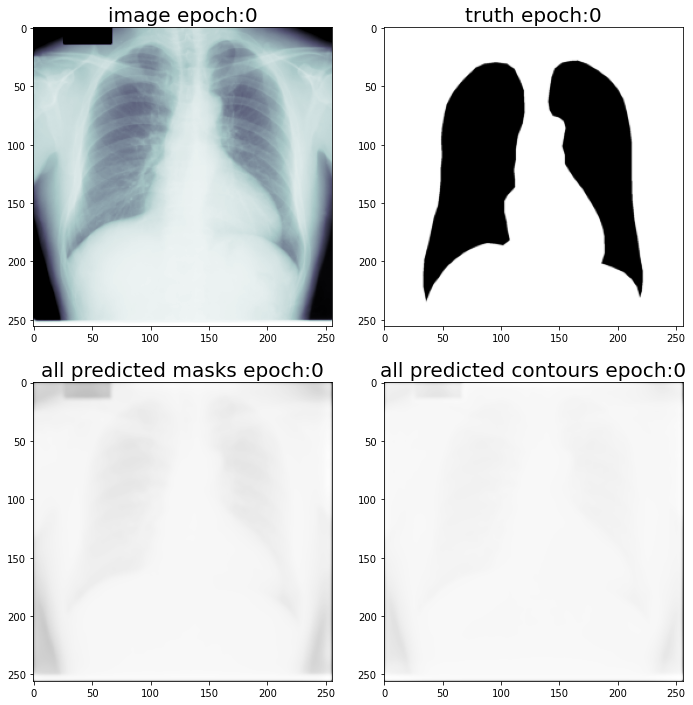

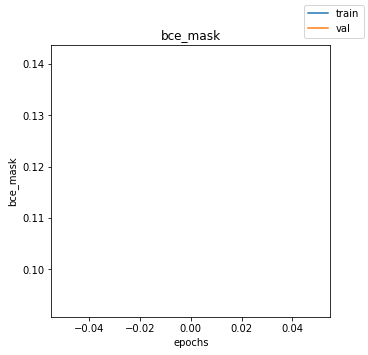

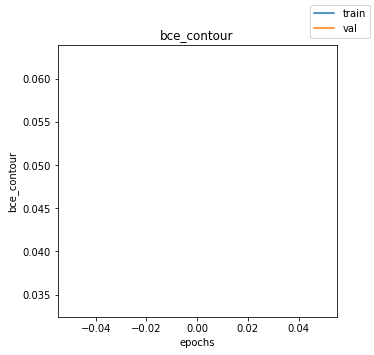

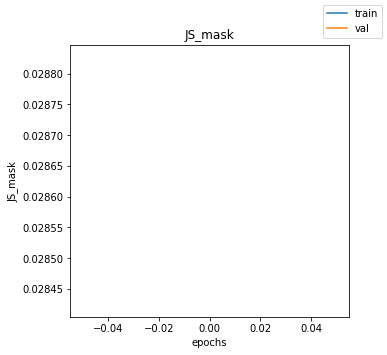

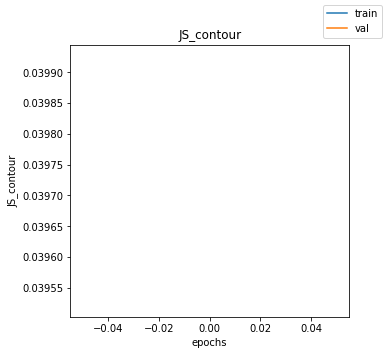

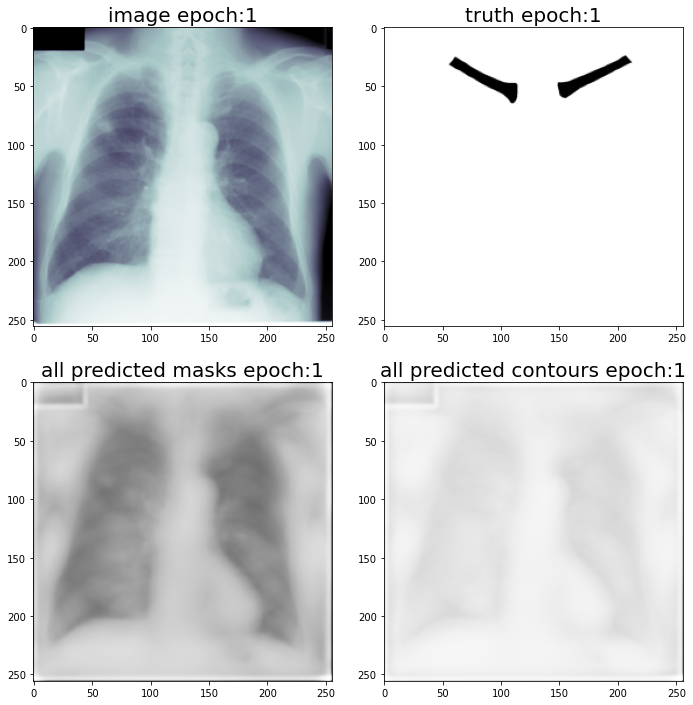

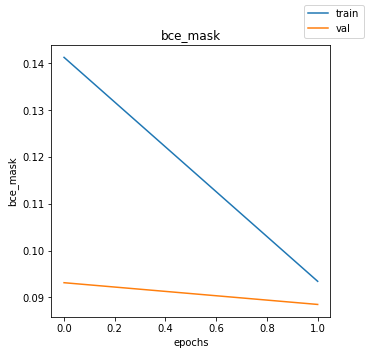

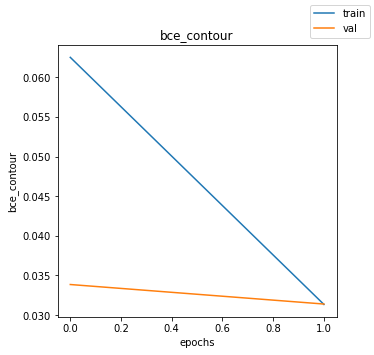

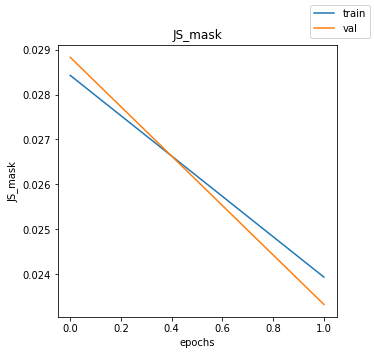

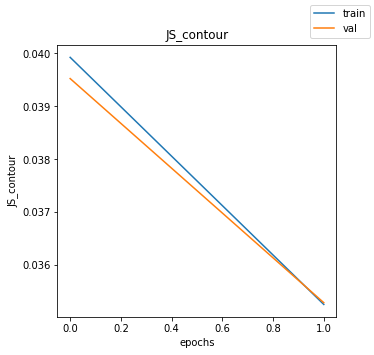

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time

LR = 1E-3
GAMMA = .9

model = EncDecResNetUNet(10).to(device)
optimizer_ft_all = optim.Adam(filter(lambda p: p.requires_grad, # require grad params will be trained. so no resnet.
                                     model.parameters()), lr=LR)

exp_lr_scheduler_all = lr_scheduler.StepLR(optimizer_ft_all, step_size=35, gamma=GAMMA)
train_model(dataloaders, 
                model,301,
                lossfn, # function form loss(target,prediction,code)
                metric_dict, # dictionary string : f(target,prediction,code) #print metrics, record in dict -> list, plot.
                optimizer = optimizer_ft_all, 
                scheduler=exp_lr_scheduler_all, 
                    visualize= visualize, # plot the mask, ground truth etc. visualize(input,prediction,target,epoch,dir) (done)
                plot_epoch = 1,
                savedir=savedrive + hyperstring)

In [ ]:
model